In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc

%load_ext autoreload
%autoreload 2

In [2]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
doses = [1, 0.75, 0.5]
plans = [(t1, t2, t3, t4) for t1 in doses for t2 in doses for t3 in doses for t4 in doses]

In [3]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

sols = [sc.score(patient_config, plan) for plan in plans]
sols = [sol for sol in sols if sol is not None]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Found {len(sols)} feasible treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.


/home/astreck/patient-informed-decision-tool/tox_model.py:32: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'object' of function 'impl_np_array.<locals>.impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../mambaforge/envs/moffitt/lib/python3.9/site-packages/numba/np/arrayobj.py", line 5252:

    def impl(object, dtype=None):
    ^

  patientToxs=np.array(sens)
/home/astreck/mambaforge/envs/moffitt/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sens' of function 'RunToxDifferenceEquation'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "tox_mo

: 

In [ ]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity"])
df_sp.head()

,S1,S2,S3,S4,burden,toxicity
0,1.0,1.0,1.00,1.00,21.375070,8.025395
1,1.0,1.0,1.00,0.75,25.527934,7.284089
2,1.0,1.0,1.00,0.50,36.368092,6.679925
3,1.0,1.0,0.75,1.00,40.906025,7.501177
4,1.0,1.0,0.75,0.75,51.314455,6.759835


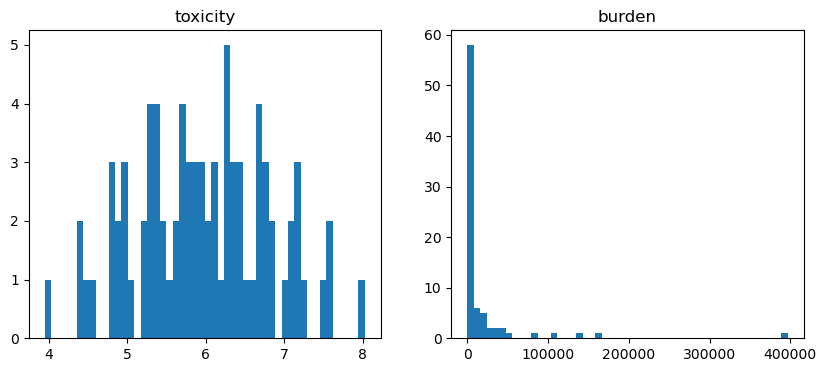

In [ ]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");

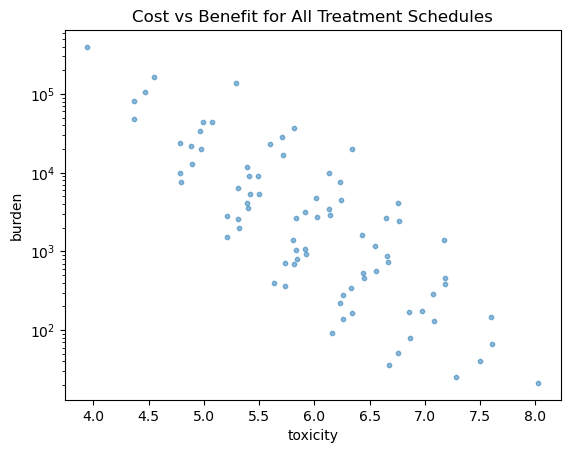

In [ ]:
plt.scatter(df_sp["toxicity"], df_sp["burden"], s=10, alpha=0.5)
# set y to log
plt.yscale("log")
plt.xlabel("toxicity")
plt.ylabel("burden")
plt.title("Cost vs Benefit for All Treatment Schedules");

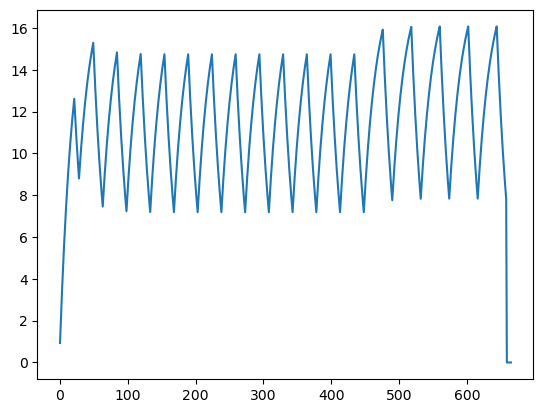

In [ ]:
for i in range(1):
    plt.plot(sols[i]["toxicity_sol"])

In [ ]:
sols[i]

{'plan': (1, 1, 1, 1),
 'schedule': array([[  1.,   1.,   0.,  21.],
        [  1.,   1.,  28.,  49.],
        [  1.,   1.,  63.,  84.],
        [  1.,   1.,  98., 119.],
        [  2.,   1., 133., 154.],
        [  2.,   1., 168., 189.],
        [  2.,   1., 203., 224.],
        [  2.,   1., 238., 259.],
        [  3.,   1., 273., 294.],
        [  3.,   1., 308., 329.],
        [  3.,   1., 343., 364.],
        [  3.,   1., 378., 399.],
        [  3.,   1., 413., 434.],
        [  4.,   1., 448., 476.],
        [  4.,   1., 490., 518.],
        [  4.,   1., 532., 560.],
        [  4.,   1., 574., 602.],
        [  4.,   1., 616., 644.]]),
 'toxicity_sol': array([ 0.93179432,  1.81699892,  2.65794329,  3.45684044,  4.21579273,
         4.93679741,  5.62175185,  6.27245858,  6.89062996,  7.47789278,
         8.03579246,  8.56579715,  9.06930161,  9.54763084, 10.00204362,
        10.43373575, 10.84384328, 11.23344543, 11.60356748, 11.95518342,
        12.28921856, 12.60655195, 11.976224